# Red neuronal con diferentes funciones de activacion y propagación de errores hacia atrás (backpropagation)

### Tipos de funciones de activación:
Fuente: https://mlfromscratch.com/activation-functions-explained/#/
![title](https://mlfromscratch.com/content/images/2019/12/activation-functions.gif)

Tómese en cuenta lo siguiente.

- Los bias y pesos son inicialmente aleatorios, pero de alguna manera se deben ajustar mediante iteraciones.
- Cada conexión tiene un peso.
- Cada neurona tiene un bias. 

### Error (métrica)
- Se requiere una métrica que mida qué tan cerca o lejos del valor esperado son las predicciones de la red (función de costo o de pérdida).
- Es necesario un algoritmo que minimize la función anterior.
- Si no se emplea una función de activación no lineal, la suma ponderada y toda la estructura de la red solamente proveerán transformaciones lineales.


Consíderese lo siguiente:


- Función de costo: 
$C(w, b) ≡ \frac{1}{2} \Sigma_x || y(x) − a(x,w,b)||^2$, donde a es la predicción de la RNA.
- Métodos analíticos de minimización no son útiles para muchas variables.
- Se requiere un algoritmo para minimizar la función de costo: descenso del gradiente.
- El descenso del gradiente únicamente calcula gradientes, es el más simple de toda una familia de algoritmos de minimización.

### Descenso del gradiente (intuición)

- La deducción no es propósito de esta notebook, pero cada nuevo paso en busca de la minimización de la función de costo, obedece la siguiente regla:

$ v -> v' = v - \eta \nabla C$, donde $v$ es $f(w, b)$ y $\eta$ la tasa de aprendizaje (tamaño de paso, learning rate)

- Se da un paso en dirección opuesta al gradiente hasta minimizar la función de costo.

- Se le llama *backpropagation* al algoritmo que realiza esto iterativamente desde la última capa hasta la primera.

Fuente: https://kevinbinz.com/2019/05/26/intro-gradient-descent/

![title](https://kevinbinz.files.wordpress.com/2019/05/dualspace_explore.gif)

- Se quiere encontrar (x,y) tal que sea un mínimo en la superficie (función de costo).

Fuente: https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c

![title](https://miro.medium.com/max/819/1*hUd744hDEEGx0-ypWGhrkw.gif)


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class NeuralNet:
    def __init__(self, X, Y, nodos, p_split, learning_rate, epocas, fn_activation='relu'):
        """
        Constructor de una red neuronal de una capa.
        
        Parametros
        ----------
        X : array-like, shape = [N, m]
            Variables independientes.
            
        y : array-like, shape = [N, 1]
            Variables dependientes.
        
        nodos : int
            Número de nodos de la capa oculta.
        
        p_split : float
            Fracción del conjunto de datos para conformar el conjunto de entrenamiento.
        
        learning_rate : float
            Tasa de aprendizaje
        
        epocas : int
            Número de épocas
        
        fn_activation : str
            Función de activación. Opciones: 'relu', 'sigmoide', 'tanh', 'identidad'.
        """
        self.X = X
        self.Y = Y
        self.nodos = nodos
        self.p_split = p_split
        self.learning_rate = learning_rate
        self.epocas = epocas
        
        if fn_activation == 'relu':
            self.activation = self.relu
            self.dactivation = self.drelu
        elif fn_activation == 'sigmoide':
            self.activation = self.sigmoid
            self.dactivation = self.dsigmoid
        elif fn_activation == 'tanh':
            self.activation = self.tanh
            self.dactivation = self.dtanh
        elif fn_activation == 'identidad':
            self.activation = self.iden
            self.dactivation = self.diden  
    
    # RELU
    def relu(self, x):
        return x * (x > 0)

    def drelu(self, x):
        return 1. * (x > 0)

    # IDENTIDAD
    def iden(self, X):
        return X

    def diden(self, X):
        return 1

    # SIGMOIDE
    def sigmoid(self, X):
        return 1/(1.0+np.exp(-X))

    def dsigmoid(self, X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    # TANH
    def tanh(self, X):
        return np.tanh(X)
    
    def dtanh(self, X):
        return 1-self.tanh(X)**2
    
    # ERROR CUADRÁTICO MEDIO (MSE)
    def error(self, vector):
        m = len(vector)
        mse = (1/(2*m))*np.linalg.norm(vector)**2
        return mse
    
    # SEPARAR CONJUNTO DE ENTRENAMIENTO Y PRUEBA
    def split(self, X, Y, p_split): #El p_split debe estar dado entre 0 y 1
        nparams = len(X)
        randomize = np.random.permutation(nparams)
        X = X[randomize]
        Y = Y[randomize]
        ntrain = int(p_split * nparams)
        indx = [ntrain]
        X_train, X_test = np.split(X, indx)
        Y_train, Y_test = np.split(Y, indx)
    
        return X_train, Y_train, X_test, Y_test
    
    # ENTRENAMIENTO DE LA RED
    def entrenar(self):
        n_entradas=len(self.X[0])
        n_salidas=len(self.Y[0])

        # definimos los conjuntos de aprendizaje y validación 
        X_learn, Y_learn, X_val, Y_val = self.split(self.X, self.Y, self.p_split)

        # Inicialización de pesos y bias
        W1 = np.random.randn(n_entradas,self.nodos)
        W2 = np.random.randn(self.nodos, n_salidas)
        b1 = np.random.randn(self.nodos)
        b2 = np.random.randn(n_salidas)

        self.errores=[]
        self.validacion=[]
        
        # Se realiza el entrenamiento hasta que se complete el número de épocas establecido
        for i in range(self.epocas):
            # propagación hacia adelante
            z1 = np.dot(X_learn, W1)+b1
            a1 = self.activation(z1)
            z2 = np.dot(a1, W2)+b2
            a2 = z2
            
            # Calcular error 
            delta2 = a2 - Y_learn
            self.errores.append(self.error(delta2)) # guardamos el error de cada época
            
            # backpropagation/propagación hacia atrás
            
            delta1 = (delta2).dot(W2.T)*self.dactivation(z1)

            W2 -= self.learning_rate * a1.T.dot(delta2)
            b2 -= self.learning_rate * (delta2).sum(axis=0)

            W1 -= self.learning_rate * X_learn.T.dot(delta1)
            b1 -= self.learning_rate * (delta1).sum(axis=0)

            print("Época: %d, Error: %f" %(i+1, self.error(delta2)))

            # Ahora validamos el modelo con el conjunto de prueba
            z1 = np.dot(X_val, W1) + b1
            a1 = self.activation(z1)
            z2 = np.dot(a1, W2)+b2
            a2 = z2
            delta = a2-Y_val
            self.validacion.append(self.error(delta))
        
        self.W1 = W1
        self.W2 = W2
        self.b1 = b1
        self.b2 = b2   

    # GRAFICAR CURVAS DE CONJUNTOS DE ENTRENAMIENTO Y PRUEBA
    def plot(self):
        plt.plot(range(self.epocas),self.errores,color='darkcyan',label='Aprendizaje')
        plt.plot(range(self.epocas),self.validacion,color='darkred',label='Validación')
        plt.grid()
        plt.legend()
     
    # EVALUAR NUEVO VALOR (PREDICCION)
    def evaluar(self, x):
        z1=np.dot(x,self.W1)+self.b1
        a1=self.activation(z1)
        z2=np.dot(a1,self.W2)+self.b2
        a2=z2
        return a2

## Ejemplo: Aprender la función del parámetro de Hubble para $\Lambda$CDM

- A partir de la expresión analítica del parámetro de Hubble para $\Lambda$CDM se generan X redshifts y Y funciones evaluadas.



In [3]:
def Hlcdm(z, Om=0.27, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)


X=2.3*np.random.rand(1000,1)
Y=Hlcdm(X, Om=0.27, H0=73.24)

- Se entrena la red neuronal con X y Y. 
- Usamos la función de activación sigmoide.
- 1000 épocas.
- 10 neuronas.
- 1 capa.
- Learning rate 1e-4

In [4]:
neuralnet = NeuralNet(X,Y,10,0.2,0.0001,1000,fn_activation='sigmoide')
neuralnet.entrenar()

Época: 1, Error: 11942.165070
Época: 2, Error: 10056.422344
Época: 3, Error: 8049.249297
Época: 4, Error: 6031.271476
Época: 5, Error: 4434.730129
Época: 6, Error: 3289.651760
Época: 7, Error: 2487.168478
Época: 8, Error: 1967.209191
Época: 9, Error: 1627.839131
Época: 10, Error: 1403.914869
Época: 11, Error: 1251.906716
Época: 12, Error: 1142.521628
Época: 13, Error: 1055.226094
Época: 14, Error: 974.808812
Época: 15, Error: 890.841449
Época: 16, Error: 801.425688
Época: 17, Error: 714.604500
Época: 18, Error: 637.425753
Época: 19, Error: 570.081863
Época: 20, Error: 511.543072
Época: 21, Error: 460.776928
Época: 22, Error: 416.640998
Época: 23, Error: 378.180737
Época: 24, Error: 344.571515
Época: 25, Error: 315.092149
Época: 26, Error: 289.120425
Época: 27, Error: 266.127264
Época: 28, Error: 245.668448
Época: 29, Error: 227.374592
Época: 30, Error: 210.940403
Época: 31, Error: 196.114019
Época: 32, Error: 182.687278
Época: 33, Error: 170.487216
Época: 34, Error: 159.369082
Época: 3

Época: 739, Error: 2.002052
Época: 740, Error: 1.942292
Época: 741, Error: 1.992202
Época: 742, Error: 1.932989
Época: 743, Error: 1.982429
Época: 744, Error: 1.923756
Época: 745, Error: 1.972732
Época: 746, Error: 1.914594
Época: 747, Error: 1.963110
Época: 748, Error: 1.905500
Época: 749, Error: 1.953563
Época: 750, Error: 1.896475
Época: 751, Error: 1.944090
Época: 752, Error: 1.887517
Época: 753, Error: 1.934690
Época: 754, Error: 1.878626
Época: 755, Error: 1.925362
Época: 756, Error: 1.869801
Época: 757, Error: 1.916105
Época: 758, Error: 1.861042
Época: 759, Error: 1.906919
Época: 760, Error: 1.852348
Época: 761, Error: 1.897802
Época: 762, Error: 1.843718
Época: 763, Error: 1.888755
Época: 764, Error: 1.835151
Época: 765, Error: 1.879776
Época: 766, Error: 1.826647
Época: 767, Error: 1.870865
Época: 768, Error: 1.818205
Época: 769, Error: 1.862020
Época: 770, Error: 1.809825
Época: 771, Error: 1.853242
Época: 772, Error: 1.801505
Época: 773, Error: 1.844529
Época: 774, Error: 1

### Se evalua las curvas del MSE para el conjunto de entrenamiento y el conjunto de validación

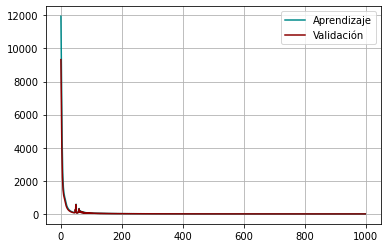

In [5]:
neuralnet.plot()

### Se comparan las predicciones de la red neuronal con la función analítica.

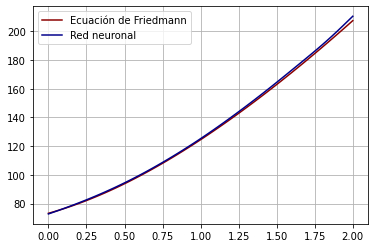

In [6]:
z=np.linspace(0,2,60)
z=z.reshape(60,1)
plt.plot(z,Hlcdm(z, Om=0.27, H0=73.24),color='darkred',label='Ecuación de Friedmann')
plt.plot(z, neuralnet.evaluar(z),label='Red neuronal',color='darkblue')
# plt.plot(X1,Y1,'.', label='Datos reales')
plt.legend()
plt.grid()

### -> Ejercicio 3 (opcional)

Aproximar otra función esta red neuronal. 

## Referencias:

- Nielsen, M. A. (2015). Neural networks and deep learning (Vol. 25). San Francisco, CA: Determination press.
- https://kevinbinz.com/2019/05/26/intro-gradient-descent/
- https://mlfromscratch.com/activation-functions-explained/#/
- https://towardsdatascience.com/a-visual-explanation-of-gradient-descent-methods-momentum-adagrad-rmsprop-adam-f898b102325c
